In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import lasio
import os
import pandas as pd

path_to_RIGIS = r'./welldata/RIGIS/'
path_to_GIS = r'./welldata/GIS_md/'
path_to_welltracks = r'./welldata/welltracks.txt'

def getLasDataFrames(path = path_to_RIGIS):
    lasDF = []
    for file in os.listdir(path):
        if file.endswith('.las'):
            lasDF.append(lasio.read(path+file).df())
    return lasDF

lasDataFrame = getLasDataFrames()

In [2]:
len(lasDataFrame)

72

In [3]:
def parse_welltracks():
    welltracks = []
    f = open(path_to_welltracks)
    welldata = f.read().split(';')
    for well in welldata:
        if len(well.split()) > 2:
            name = well.split()[2][:-1]
            data = well.split()[3:]
            x = [float(data[i]) for i in range(len(data)) if i % 4 == 0]
            y = [float(data[i]) for i in range(len(data)) if i % 4 == 1]
            tvdss = [float(data[i]) for i in range(len(data)) if i % 4 == 2]
            md = [float(data[i]) for i in range(len(data)) if i % 4 == 3]

            welltracks.append([name, x, y ,tvdss, md]) # в таком виде хранятся

    return welltracks


In [4]:
from scipy.interpolate import interp1d
import math
def get_heights_list():
    welltracks = parse_welltracks()
    tvdconv = []
    for tracknum in range(len(welltracks)):
        f = interp1d(welltracks[tracknum][4], welltracks[tracknum][3])
        tvdconv.append(f)

    heights = []
    print(len(lasDataFrame))
    for k  in range(len(lasDataFrame)):
        frame = lasDataFrame[k]
        tmp_sum = 0
        for i in range(len(frame['KG_T']) - 1):
            if (frame['KG_T'].array[i + 1] >= 0):
                tmp_sum += tvdconv[k](frame['KG_T'].index[i + 1]) - tvdconv[k](frame['KG_T'].index[i])
        heights.append(tmp_sum)
    return heights
get_heights_list()

72


[25.130624479999938,
 35.88004108000018,
 27.795775679999906,
 21.800000000000068,
 35.19999999999993,
 40.299999999999955,
 30.4990808,
 42.698541400000295,
 11.999999999999886,
 31.70000000000016,
 20.690719200000103,
 41.49842736000005,
 23.09999999999991,
 24.090025479999895,
 11.299596400000269,
 0,
 17.495392559999914,
 21.397067200000038,
 11.999999999999886,
 13.591869410256322,
 25.154023750000192,
 0,
 32.09999999999991,
 27.29590500000006,
 0,
 34.48551523999993,
 24.399999999999977,
 3.7000000000000455,
 27.100000000000023,
 26.399999999999864,
 14.792895520000116,
 28.3968676799999,
 12.5,
 40.196461600000134,
 31.99016499999982,
 26.09829259999981,
 25.99995783999998,
 38.799999999999955,
 22.49229216000026,
 0,
 3.0999886999998125,
 31.99061487999984,
 35.299358400000074,
 0,
 0,
 26.610106400000177,
 25.25229369999977,
 0,
 28.290335360000086,
 21.39962960000014,
 27.47094096000012,
 25.735108899999886,
 35.1975988800001,
 39.88842999999997,
 22.59899109999992,
 23.5694

In [5]:
def dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2+(y1-y2)**2)
def perimeter(boundary):
    (prev_x,prev_y) = boundary[-1]
    perim = 0
    for (x,y) in boundary:
        perim += dist(x,y,prev_x,prev_y)
        prev_x, prev_y = x,y
    return perim
def getCommonLength(boundary1, boundary2):
    len = 0
    for i in range(int(boundary1.size/2 - 1)):
        for j in range(int(boundary2.size/2 - 1)):
            (x1, y1) = boundary1[i]
            (x2, y2) = boundary2[j]
            if(x1 == x2 and y1== y2):
                len += dist(x1,x2,y1,y2)
    return len
    


len(region_polys) =  77



/tmp/ipykernel_9817/4054569072.py:25: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  perimeters.append(perimeter(np.array(region_polys[i].boundary)))
/tmp/ipykernel_9817/4054569072.py:25: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  perimeters.append(perimeter(np.array(region_polys[i].boundary)))
/tmp/ipykernel_9817/4054569072.py:25: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have t

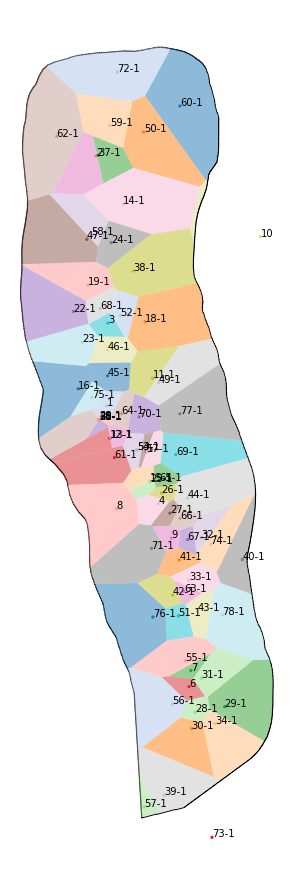

/home/evgeny/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_9817/4054569072.py:36: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  mat_size = np.array(boundaries).size
/tmp/ipykernel_9817/4054569072.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays w

mat size is  76
76
0  and  1  are neibors
0  and  2  are neibors
0  and  16  are neibors
1  and  0  are neibors
1  and  2  are neibors
1  and  3  are neibors


KeyboardInterrupt: 

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely import geometry
from shapely.ops import cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from main import parse_welltracks

welltracks = parse_welltracks()
boundary = np.load("boundary.npy",'r') 

c = np.array([(track[1][0], track[2][0]) for track in welltracks])
s = geometry.Polygon(boundary)
region_polys, region_pts = voronoi_regions_from_coords(c, s)
perimeters = []
boundaries = []
new_polys = []
print('len(region_polys) = ', len(region_polys))
for i in range(len(region_polys)):
    #print(type(region_polys[i]))
    try:
        new_polys.append(region_polys[i])
        perimeters.append(perimeter(np.array(region_polys[i].boundary)))
        boundaries.append(region_polys[i].boundary)
    except Exception:
        print()

#print(perimeters)
fig, ax = subplot_for_map(figsize=(18, 16))
for i in range(len(welltracks)):
    ax.annotate(welltracks[i][0], (welltracks[i][1][0], welltracks[i][2][0]), fontsize=10)
plot_voronoi_polys_with_points_in_area(ax, s, region_polys, c, region_pts)
plt.show()
mat_size = np.array(boundaries).size
print('mat size is ', mat_size)
adj_mat = [np.array([-1 for i in range(mat_size)]) for j in range(mat_size)]
print(np.array(boundaries).size)
for i in range(mat_size):
    for j in range(mat_size):
        if i == j:
            adj_mat[i][j] = 0
            continue
        adj_mat[i][j] = getCommonLength(np.array(boundaries[i]), np.array(boundaries[j]))
        if(adj_mat[i][j] > 0):
            print(i, ' and ', j, ' are neibors')
print(adj_mat)



